#  SARSA and Q-Learning

SARSA and Q-learning are two one-step, tabular TD (Temporal Difference) algorithms that both estimate the value functions and optimize the policy, and that can actually be used in a great variety of RL problems.

## SARSA
The name **SARSA** comes from the update that is based on the state, $s_t$; the action, $a_t$; the reward, $r_t$; the next state, $s_{t+1}$; and finally, the next action, $a_{t+1}$.   Putting everything together, it forms $s, a, r, s, a$.

![SARSA update](images/sarsa.png)

### SARSA: On-Policy Learning
**SARSA** is an *on-policy* algorithm (learns from actions taken by the current policy).  

On-policy means that the policy used to collect experience through interaction with the environment (the **behavior policy**) is **the same policy that is updated**.  

The on-policy nature comes from using the current policy to select the next action, $a_{t+1}$, to estimate $Q(s_{t+1}, a_{t+1})$, and assuming that future actions will also follow the same policy (that is, the agent acts according to that policy).

#### Update Rule

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \big[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)\big]
$$


## Setup

In [1]:
!pip install gymnasium matplotlib numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## SARSA Example

**Taxi-v3** is a game that was introduced to study hierarchical reinforcement learning (a type of RL algorithm that creates a hierarchy of policies, each with the goal of solving a subtask) where the aim is to pick up a passenger and drop them at a precise location. A reward of +20 is earned when the taxi performs a successful drop-off, but a penalty of -10 is incurred for illegal pickup or drop-off.

![Start state of the Taxi-v3 environment](images/taxi_v3.png)

In [ ]:
import numpy as np
import gymnasium as gym

def greedy(Q, s):
    """
    Greedy policy: returns the index of the action with the highest Q-value.
    """
    return np.argmax(Q[s])

def eps_greedy(Q, s, eps=0.1):
    """
    Epsilon-greedy policy.
    """
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(Q.shape[1])
    else:
        return greedy(Q, s)

def run_episodes(env, Q, num_episodes=100, to_print=False):
    """
    Run several episodes to test the current policy.
    """
    tot_rew = []
    state, info = env.reset()

    for _ in range(num_episodes):
        done = False
        game_rew = 0

        while not done:
            next_state, rew, terminated, truncated, info = env.step(greedy(Q, state))
            done = terminated or truncated

            state = next_state
            game_rew += rew

            if done:
                state, info = env.reset()
                tot_rew.append(game_rew)

    if to_print:
        print('Mean score: %.3f of %i games!' % (np.mean(tot_rew), num_episodes))

    return np.mean(tot_rew)

def SARSA(env, lr=0.01, num_episodes=10000, eps=0.3, gamma=0.95, eps_decay=0.00005):
    nA = env.action_space.n
    nS = env.observation_space.n

    # Initialize the Q matrix
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []
    episodes_list = []

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        tot_rew = 0

        # decay the epsilon value until it reaches the threshold of 0.01
        if eps > 0.01:
            eps -= eps_decay


        action = eps_greedy(Q, state, eps) 

        # loop the main body until the environment stops
        while not done:
            next_state, rew, terminated, truncated, info = env.step(action) # Take one step in the environment
            done = terminated or truncated

            # choose the next action (needed for the SARSA update)
            next_action = eps_greedy(Q, next_state, eps) 
            # SARSA update
            Q[state][action] = Q[state][action] + lr*(rew + gamma*Q[next_state][next_action] - Q[state][action])

            state = next_state
            action = next_action
            tot_rew += rew
            if done:
                games_reward.append(tot_rew)

        # Test the policy every 2 episodes and print the results
        if (ep % 2) == 0:
            test_rew = run_episodes(env, Q, 1000)
            print("Episode:{:5d}  Eps:{:2.4f}  Rew:{:2.4f}".format(ep, eps, test_rew))
            test_rewards.append(test_rew)
            episodes_list.append(ep)

        if ep == 500:
            np.save("models/Q_sarsa_500ep.npy", Q)

    np.save("models/Q_sarsa.npy", Q)
    return Q, test_rewards, episodes_list

# Run the SARSA algorithm
env = gym.make('Taxi-v3')
Q_sarsa, rewards_sarsa, episodes_sarsa = SARSA(env, lr=.1, num_episodes=5000, eps=0.4, gamma=0.95, eps_decay=0.001)

Episode:    0  Eps:0.3990  Rew:-209.0000
Episode:    2  Eps:0.3970  Rew:-200.0000
Episode:    4  Eps:0.3950  Rew:-296.9390
Episode:    6  Eps:0.3930  Rew:-352.5050
Episode:    8  Eps:0.3910  Rew:-411.7970
Episode:   10  Eps:0.3890  Rew:-422.6240
Episode:   12  Eps:0.3870  Rew:-384.9770
Episode:   14  Eps:0.3850  Rew:-352.7660
Episode:   16  Eps:0.3830  Rew:-340.2650
Episode:   18  Eps:0.3810  Rew:-336.5300
Episode:   20  Eps:0.3790  Rew:-287.8400
Episode:   22  Eps:0.3770  Rew:-338.1590
Episode:   24  Eps:0.3750  Rew:-226.9640
Episode:   26  Eps:0.3730  Rew:-246.6380
Episode:   28  Eps:0.3710  Rew:-241.1660
Episode:   30  Eps:0.3690  Rew:-239.5010
Episode:   32  Eps:0.3670  Rew:-255.7910
Episode:   34  Eps:0.3650  Rew:-280.9370
Episode:   36  Eps:0.3630  Rew:-232.3550
Episode:   38  Eps:0.3610  Rew:-248.5460
Episode:   40  Eps:0.3590  Rew:-303.9590
Episode:   42  Eps:0.3570  Rew:-264.5030
Episode:   44  Eps:0.3550  Rew:-280.5050
Episode:   46  Eps:0.3530  Rew:-267.9320
Episode:   48  E

In [ ]:
import matplotlib.pyplot as plt

window = 3
smoothed = np.convolve(rewards_sarsa, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8, 5))
plt.plot(episodes_sarsa[:len(smoothed)], smoothed, color='orange', linewidth=2)
plt.title("Smoothed Q-Learning Reward")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Average Reward")
plt.grid(True)
plt.show()

## Test SARSA Model

In [2]:
# load the trained Q-table
Q_loaded = np.load("models/Q_sarsa.npy")

env = gym.make("Taxi-v3", render_mode="ansi")

# Greedy policy
def greedy(Q, s):
    return np.argmax(Q[s])

# Test the trained agent
state, info = env.reset()
done = False
total_reward = 0

while not done:
    action = greedy(Q_loaded, state)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    print(env.render())  # text visualization
    state = next_state

print(f"\nTotal reward: {total_reward}")
env.close()

NameError: name 'np' is not defined

## Q-Learning
**Q-learning** is a type of reinforcement learning algorithm that learns the optimal policy off-policy, meaning that it learns about the best possible actions to take, regardless of which actions are actually taken during training (It approximates the Q-function by using the current optimal action value).

It approximates the Q-function by using the current optimal action value.

The Q-learning update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \big[ r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \big]
$$

where:
- $ \alpha $ is the learning rate,  
- $ \gamma $ is the discount factor.

While **SARSA** updates based on the action actually taken by the current policy (on-policy),
**Q-learning** updates using the *maximum* possible next action value, even if that action was not taken.  
This makes Q-learning an **off-policy** algorithm.

![Q-learning update](images/qlearning.png)

## Q-Learning Example

In [2]:
import os
import numpy as np
import gymnasium as gym

def greedy(Q, s):
    """
    Greedy policy: returns the index of the action with the highest Q-value.
    """
    return np.argmax(Q[s])

def eps_greedy(Q, s, eps=0.1):
    """
    Epsilon-greedy policy.
    """
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(Q.shape[1])
    else:
        return greedy(Q, s)

def run_episodes(env, Q, num_episodes=100, to_print=False):
    """
    Run several episodes to test the current policy.
    """
    tot_rew = []
    state, info = env.reset()

    for _ in range(num_episodes):
        done = False
        game_rew = 0

        while not done:
            next_state, rew, terminated, truncated, info = env.step(greedy(Q, state))
            done = terminated or truncated

            state = next_state
            game_rew += rew

            if done:
                state, info = env.reset()
                tot_rew.append(game_rew)

    if to_print:
        print('Mean score: %.3f of %i games!' % (np.mean(tot_rew), num_episodes))

    return np.mean(tot_rew)

def Q_learning(env, lr=0.01, num_episodes=10000, eps=0.3, gamma=0.95, eps_decay=0.00005):
    """
    Q-Learning implementation with epsilon-greedy exploration.
    """
    nA = env.action_space.n
    nS = env.observation_space.n

    # Initialize the Q matrix
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    Q = np.zeros((nS, nA))
    games_reward = []
    test_rewards = []
    episodes_list = []

    os.makedirs("models", exist_ok=True)

    for ep in range(num_episodes):
        state, info = env.reset()
        done = False
        tot_rew = 0

        # decay the epsilon value until it reaches the threshold of 0.01
        if eps > 0.01:
            eps -= eps_decay

        # loop the main body until the environment stops
        while not done:
            # select an action following the eps-greedy policy
            action = eps_greedy(Q, state, eps)

            next_state, rew, terminated, truncated, info = env.step(action) # Take one step in the environment
            done = terminated or truncated

            # Q-learning update the state-action value (get the max Q value for the next state)
            Q[state][action] = Q[state][action] + lr * (rew + gamma * np.max(Q[next_state]) - Q[state][action])

            state = next_state
            tot_rew += rew

            if done:
                games_reward.append(tot_rew)

        #Test the policy every 2 episodes
        if (ep % 2) == 0:
            test_rew = run_episodes(env, Q, 1000)
            print(f"Episode:{ep:5d}  Eps:{eps:2.4f}  Rew:{test_rew:2.4f}")
            test_rewards.append(test_rew)
            episodes_list.append(ep)
        
        if ep == 500: 
            # save trained model
            np.save("models/Q_qlearning_500ep.npy", Q)

    np.save("models/Q_qlearning.npy", Q)
    return Q, test_rewards, episodes_list

# Run the Q-learning algorithm
env = gym.make('Taxi-v3') 
Q_qlearning, test_rewards, episodes = Q_learning(env, lr=0.1, num_episodes=5000, eps=0.4, gamma=0.95, eps_decay=0.001)


Episode:    0  Eps:0.3990  Rew:-227.0000
Episode:    2  Eps:0.3970  Rew:-219.7640
Episode:    4  Eps:0.3950  Rew:-300.5750
Episode:    6  Eps:0.3930  Rew:-306.0020
Episode:    8  Eps:0.3910  Rew:-375.7970
Episode:   10  Eps:0.3890  Rew:-334.7300
Episode:   12  Eps:0.3870  Rew:-402.4370
Episode:   14  Eps:0.3850  Rew:-368.4980
Episode:   16  Eps:0.3830  Rew:-391.5650
Episode:   18  Eps:0.3810  Rew:-389.7290
Episode:   20  Eps:0.3790  Rew:-384.6710
Episode:   22  Eps:0.3770  Rew:-427.5290
Episode:   24  Eps:0.3750  Rew:-388.1180
Episode:   26  Eps:0.3730  Rew:-294.9050
Episode:   28  Eps:0.3710  Rew:-311.0420
Episode:   30  Eps:0.3690  Rew:-319.9970
Episode:   32  Eps:0.3670  Rew:-316.3790
Episode:   34  Eps:0.3650  Rew:-302.0690
Episode:   36  Eps:0.3630  Rew:-296.6240
Episode:   38  Eps:0.3610  Rew:-300.1970
Episode:   40  Eps:0.3590  Rew:-260.7410
Episode:   42  Eps:0.3570  Rew:-262.6040
Episode:   44  Eps:0.3550  Rew:-230.4830
Episode:   46  Eps:0.3530  Rew:-243.1010
Episode:   48  E

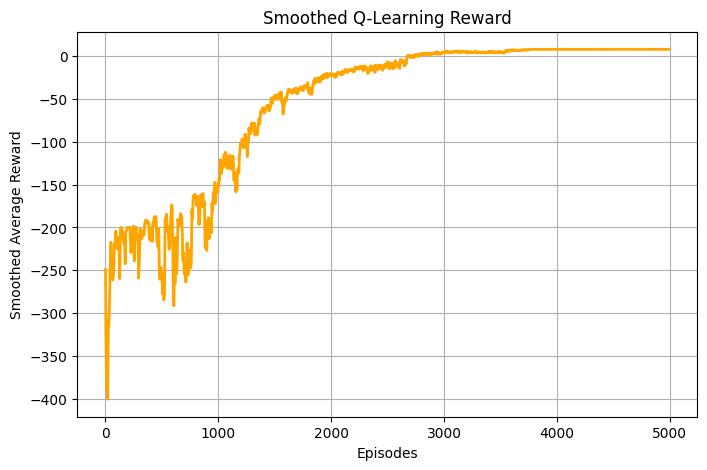

In [3]:
import matplotlib.pyplot as plt

window = 3
smoothed = np.convolve(test_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8, 5))
plt.plot(episodes[:len(smoothed)], smoothed, color='orange', linewidth=2)
plt.title("Smoothed Q-Learning Reward")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Average Reward")
plt.grid(True)
plt.show()

## Test Q-Learning Model

In [4]:
# load the trained Q-table
Q_loaded = np.load("models/Q_qlearning.npy")

env = gym.make("Taxi-v3", render_mode="ansi")

# Greedy policy
def greedy(Q, s):
    return np.argmax(Q[s])

# Test the trained agent
state, info = env.reset()
done = False
total_reward = 0

while not done:
    action = greedy(Q_loaded, state)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    print(env.render())  # text visualization
    state = next_state

print(f"\nTotal reward: {total_reward}")
env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | 